In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
from scipy import stats # Statistical library
from sklearn.decomposition import PCA # PCA from scikit-learn

sys.path.append('../')
from src import utils, plots, tests, enrich

warnings.filterwarnings('ignore')

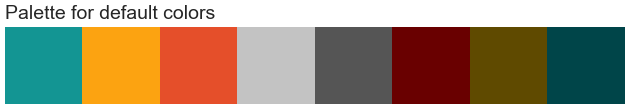

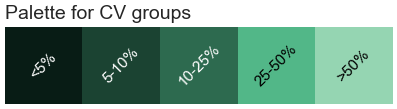

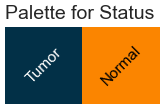

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

cv_group_palettes = {
    "<5%":  "#081c15",  
    "5-10%":  "#1b4332",  
    "10-25%": "#2d6a4f",  
    "25-50%": "#52b788",  
    ">50%": "#95d5b2",  
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    cv_group_palettes,
    name="CV groups",
    save=False
)

plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

## Template for saving figures
# plots.save_figures(
#     plt.gcf(),
#     filename="the filename without extension",
#     filepath=figure_path,
#     fileformat=figure_formats,
#     dpi=figure_dpi,
#     transparent=transparet_bg
# )

In [3]:
notebook_name = "7_spectranoutAnalysis"
data_path = "./data/processed/"
output_path = f"./data/results/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load the data

### Metadata

In [4]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Protein Quant


In [5]:
protein_quan = feather.read_dataframe("./data/prepared/NBL_directDIA_May2024_protein.feather")[metadata["UniqueNames"]]
# Get the protein list for min 4 peptides and at least 5 rep quantified in at least one condition
proteins2subset = list(
    feather.read_dataframe('./data/results/expanded_info_data_updated.feather')['Protein'].unique()
)
background = list(set(protein_quan.index))
# If value is lower than 8 set NaN
protein_quan[protein_quan < 8] = np.nan
protein_quan.index.name = "Protein"
protein_quan = protein_quan.loc[proteins2subset]
utils.print_shape(protein_quan, "Protein Level Data")
protein_quan.head()

Protein Level Data data has 7,484 rows and 20 columns


UniqueNames,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-80_Slot1-71,NBL-macro-79_Slot1-63,NBL-macro-82_Slot1-65,NBL-macro-108_Slot1-19,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-9_Slot1-43,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-107_Slot1-18,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28
Protein,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,1855.4700,NaN,1893.8022,1361.8796,NaN,NaN,1884.7361,526.5074,1280.2126,199.4570,1166.2010,1978.5979,1213.7629,605.3120,578.8004,565.4798,321.8943,624.5991,1365.5754,1101.2657
A0A075B6K5,1507.2709,1097.6561,1184.3339,1156.7177,NaN,5373.1641,1272.0674,1601.3699,1276.2145,894.3259,1410.8591,1308.1904,1298.1375,609.1823,325.7835,3279.4739,1427.9944,1704.5715,404.8354,1431.6282
A0A075B6S2,3772.1375,10674.4531,5257.3530,4896.1553,NaN,NaN,207.1562,2116.0134,828.8357,2423.9380,6923.8569,5540.8784,4397.5049,4729.4829,2138.7249,7572.6816,1336.4573,3190.0374,333.0234,2633.4231
A0A0B4J1V6,1038.9443,NaN,704.1123,951.5694,1367.4969,NaN,973.6866,1119.1226,418.0351,1701.9666,1490.7946,2077.7407,902.3618,512.5729,548.0891,495.4780,461.4948,1168.6359,1103.4318,982.0004
A0A0B4J2H0,5275.2124,NaN,4182.8052,4605.5005,13143.7793,NaN,2352.6089,3827.0603,1961.5730,1042.5764,15172.5957,10270.5508,11241.1484,3256.1199,1393.8033,1518.7997,1151.9329,6096.7031,5235.1499,4488.8462


In [6]:
status_dict = {
    "Tumor": metadata[metadata["Group"] == "Tumor"]["UniqueNames"].values.tolist(),
    "Normal": metadata[metadata["Group"] == "Normal"]["UniqueNames"].values.tolist(),
}
sample_colors = {
    metadata["UniqueNames"].values[i]: status_colors[metadata["Group"].values[i]] for i in range(metadata.shape[0])
}


# Data Preprocessing

## Initial Look at the Data

### Boxplot

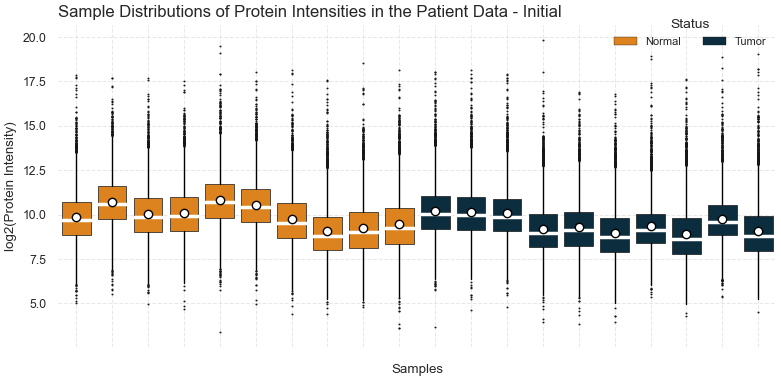

In [7]:
plot_data = np.log2(protein_quan).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    metadata[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data - Initial", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Initial_IntensityDistribution_Boxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [8]:
remove_samples = ['NBL-macro-80_Slot1-71', 'NBL-macro-109_Slot1-20']
protein_quan = protein_quan.drop(remove_samples, axis=1)
metadata = metadata[~metadata["UniqueNames"].isin(remove_samples)]
status_dict = {
    "Tumor": metadata[metadata["Group"] == "Tumor"]["UniqueNames"].values.tolist(),
    "Normal": metadata[metadata["Group"] == "Normal"]["UniqueNames"].values.tolist(),
}

### Impute Fully Missing Proteins per Group

In [9]:
shiftMag = 1.0
lowPctl = 0.15
print(f"Number of missing values in the dataset: {protein_quan.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {protein_quan.isna().sum().sum() / protein_quan.size * 100:.2f}%")
print()

print("Replacing downshifted-low values for fully missing proteins in a group:")
print("Parameters:")
print(f"  - Shift Magnitude: {shiftMag}")
print(f"  - Low Percentile: {lowPctl}")
print()

def find_downshift_mean(data, shiftMag=1, lowPct=0.1):
    flatten_data = data.values.flatten()
    flatten_data = flatten_data[~np.isnan(flatten_data)]
    lowVal = np.percentile(flatten_data, lowPctl)
    lowDist = flatten_data[flatten_data < lowVal]
    downshifted = lowDist - shiftMag
    return downshifted.mean()
    
imputed_data = np.log2(protein_quan).copy()

# Imputation loop (Updated with vectorization)
for k, v in status_dict.items():
    isMiss = imputed_data[v].isna()
    fullMiss = isMiss.sum(axis=1) == len(v)

    # Calculate SDs from the full quantified samples for each column
    sd = imputed_data[v].dropna(how="all").std(axis=1)
    sdDist = np.random.choice(sd, size=fullMiss.sum(), replace=True)

    # Calculate downshifted means for all columns at once (vectorized)
    means = find_downshift_mean(imputed_data[v], shiftMag, lowPctl)

    # Impute missing values using the calculated means and SDs (vectorized)
    imputed_values = np.random.normal(means, sdDist[:, np.newaxis], (fullMiss.sum(), len(v)))
    # # Clip the values to the shifted minimum
    # imputed_values = np.clip(imputed_values, lowVal - shiftMag, None)
    imputed_data.loc[fullMiss, v] = imputed_values

imputed_data = 2 ** imputed_data

print(f"Number of missing values in the dataset: {imputed_data.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {imputed_data.isna().sum().sum() / imputed_data.size * 100:.2f}%")
print("Number of fully quantified proteins: ", imputed_data.dropna().shape[0])

Number of missing values in the dataset: 16061
Pct of missing values in the dataset: 11.92%

Replacing downshifted-low values for fully missing proteins in a group:
Parameters:
  - Shift Magnitude: 1.0
  - Low Percentile: 0.15

Number of missing values in the dataset: 14990
Pct of missing values in the dataset: 11.13%
Number of fully quantified proteins:  4277


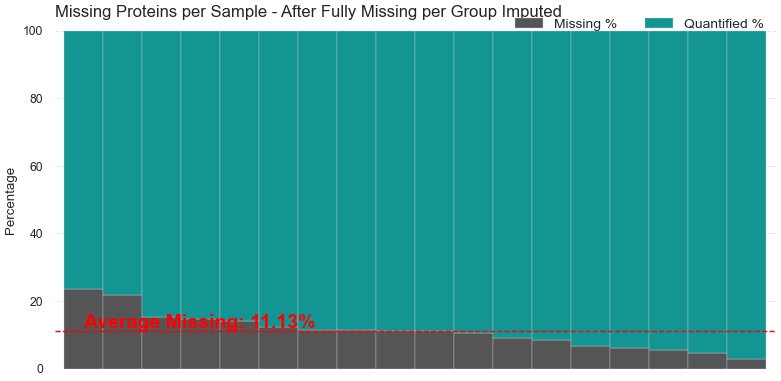

In [10]:
plot_data = imputed_data.isna().sum(axis=0).sort_values(ascending=False).to_frame(name="Missing")
plot_data["Quantified"] = imputed_data.shape[0] - plot_data["Missing"]
plot_data["Total"] = imputed_data.shape[0]
plot_data["Missing %"] = plot_data["Missing"] / plot_data["Total"] * 100
plot_data["Quantified %"] = plot_data["Quantified"] / plot_data["Total"] * 100

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

plot_data[["Missing %", "Quantified %"]].plot(
    ax=ax, kind="bar", stacked=True, 
    color=[def_colors[4], def_colors[0]],
    edgecolor="lightgrey",
    linewidth=0.25,
    width=1,
    # legend=False
)
# Add line at average missing percentage
avg_missing = plot_data["Missing %"].mean()
ax.axhline(
    avg_missing,
    color="red",
    linestyle="--",
    linewidth=1,
    # label=f"Average Missing: {avg_missing:.2f}%"
)
#Text for the average missing percentage
ax.text(
    0, avg_missing + 1, f"Average Missing: {avg_missing:.2f}%", 
    color="red", fontsize=14, fontweight="bold"
)

# Set the title and labels
ax.set_ylim(0, 100)
ax.set_xlabel("")
# Remove xticks
ax.set_xticks([])
ax.set_ylabel("Percentage")
ax.set_title("Missing Proteins per Sample - After Fully Missing per Group Imputed", fontsize=12, loc="left", pad=10)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(loc="upper right", ncol=2, title_fontsize=12, fontsize=10, frameon=False, bbox_to_anchor=(1, 1.075))
sns.despine(left=True, bottom=True)
plt.tight_layout()

plots.save_figures(
    plt.gcf(),
    filename="AfterFullyMissingImputed_MissingPerSample_StackedBar",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### KNN Imputation for the Rest of the Missing Values 

The rest of the missing values will be imputed with KNN imputation. This is to ensure that the missing values are imputed with the most similar samples. KNN is generally used for the missing values that doesn't have a pattern and it is a good imputation method after the initial imputation methods I've used.

In [11]:
knnTimer = utils.getTime()
totalMissing = imputed_data.isna().sum().sum()
# KNN Imputation for the remaining MAR values
print(f"Number of missing values in the dataset: {totalMissing}")
print(f"Pct of missing values in the dataset: {totalMissing / imputed_data.size * 100:.2f}%")
print()

print("Imputing the remaining MAR values with KNN imputation.")
print()
imputed_data_new = utils.knn_imputation(np.log2(imputed_data), n_neighbors=5)
imputed_data_new = 2 ** imputed_data_new

print(f"Number of missing values in the dataset: {imputed_data_new.isna().sum().sum()}")
print(f"Pct of missing values in the dataset: {imputed_data_new.isna().sum().sum() / imputed_data_new.size * 100:.2f}%")
print()

print(f"kNN Execution Time for {totalMissing} missing values:", utils.prettyTimer(utils.getTime() - knnTimer))

Number of missing values in the dataset: 14990
Pct of missing values in the dataset: 11.13%

Imputing the remaining MAR values with KNN imputation.

Number of missing values in the dataset: 0
Pct of missing values in the dataset: 0.00%

kNN Execution Time for 14990 missing values: 00h:00m:02s


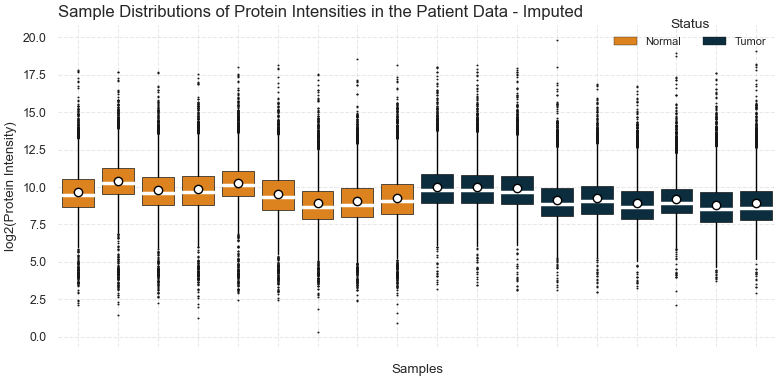

In [12]:
plot_data = np.log2(imputed_data_new).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    metadata[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)

# Set the x-axis labels
ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data - Imputed", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Imputed_IntensityDistribution_Boxplots",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

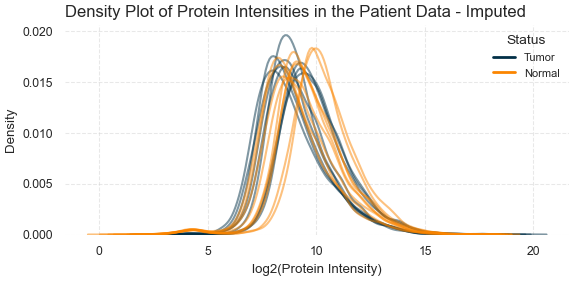

In [13]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(imputed_data_new),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Protein Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Protein Intensities in the Patient Data - Imputed", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plots.save_figures(
    plt.gcf(),
    filename="Imputed_IntensityDistribution_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Normalization

In [14]:
# Normalize the data by Centering Medians

centered_data = imputed_data_new.copy()

centered_data = (
    (centered_data / centered_data.median()) * 
    (2**(int(np.log2(centered_data.mean(axis=1).median()))))
)

# Save the Centered Data
centered_data.to_feather(f"{output_path}centered_protein_data.feather")

centered_data.describe()

UniqueNames,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-79_Slot1-63,NBL-macro-82_Slot1-65,NBL-macro-108_Slot1-19,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-9_Slot1-43,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-107_Slot1-18,NBL-macro-117_Slot1-28
count,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000,7484.0000
mean,1276.8688,1100.3153,1239.0263,1272.9148,1118.1099,1367.8039,1483.6114,1483.9630,1541.8265,1337.7973,1299.2946,1356.7805,1499.9390,1236.3527,1365.5588,1383.3290,1716.3025,1862.3972
std,4696.3944,2663.2251,3621.6641,3566.2177,3257.4148,5453.6201,6277.6493,7063.5584,5858.8739,4895.5146,4697.2125,5033.0969,13030.3156,3740.6274,4245.3058,9280.6252,7777.7682,12821.4411
min,3.1197,1.1454,3.1638,1.5134,2.4352,4.2625,1.5212,6.0106,1.7946,5.1751,6.3848,5.4255,9.7526,7.5198,11.9323,4.5002,18.7798,9.9851
25%,297.3930,304.2512,288.2084,290.7909,299.9012,276.0652,293.9792,287.2980,278.4822,282.0059,280.3212,290.3546,292.3744,283.4682,287.1770,315.8258,280.2354,293.4699
50%,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000
75%,1069.4244,1030.1013,1092.5305,1090.0113,976.9362,1137.4024,1075.1310,1139.1214,1136.3356,1082.8292,1063.1441,1053.4872,1064.4088,1061.9423,1087.1587,970.1219,1147.5185,1124.2203
max,173112.6747,86449.3950,140921.7621,121787.8547,117072.1966,232331.5956,243969.0646,434943.4111,272210.7581,155029.1119,166412.5086,156007.2116,1030677.2049,119739.5694,140118.3671,510174.2819,278285.6410,710168.9383


# Downstream Analysis

## Initial Look at the Data

### Normality Check with QQ-Plot

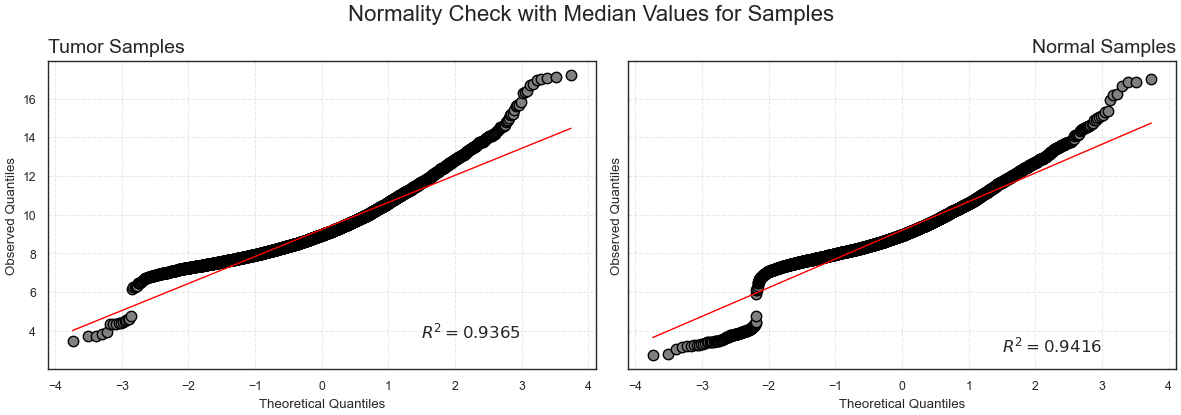

In [15]:

fig, axes = plt.subplots(nrows=1, ncols=2 , figsize=(12, 4), sharey=True)
## Tumor Samples
stats.probplot(np.log2(centered_data[status_dict["Tumor"]].median(axis=1)), dist='norm', plot=axes[0], rvalue=True)
# Update the point markers
axes[0].get_lines()[0].set_markerfacecolor('grey')
axes[0].get_lines()[0].set_markeredgecolor('black')
axes[0].get_lines()[0].set_markersize(7.5)
# Update the line
axes[0].get_lines()[1].set_linewidth(1)
axes[0].get_lines()[1].set_color('red')
# Update the text
axes[0].get_children()[2].set_fontsize(12)
# Remove the title
axes[0].set_title("")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Observed Quantiles")
axes[0].set_title("Tumor Samples", fontsize=14, loc="left")
axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
## Normal Samples
stats.probplot(np.log2(centered_data[status_dict["Normal"]].median(axis=1)), dist='norm', plot=axes[1], rvalue=True)
# Update the point markers
axes[1].get_lines()[0].set_markerfacecolor('grey')
axes[1].get_lines()[0].set_markeredgecolor('black')
axes[1].get_lines()[0].set_markersize(7.5)
# Update the line
axes[1].get_lines()[1].set_linewidth(1)
axes[1].get_lines()[1].set_color('red')
# Update the text
axes[1].get_children()[2].set_fontsize(12)
# Remove the title
axes[1].set_title("")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Observed Quantiles")
axes[1].set_title("Normal Samples", fontsize=14, loc="right")
axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
fig.tight_layout()
fig.suptitle("Normality Check with Median Values for Samples", fontsize=16, y=1.05)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="NormalityCheck_MedianValues_QQPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Boxplot

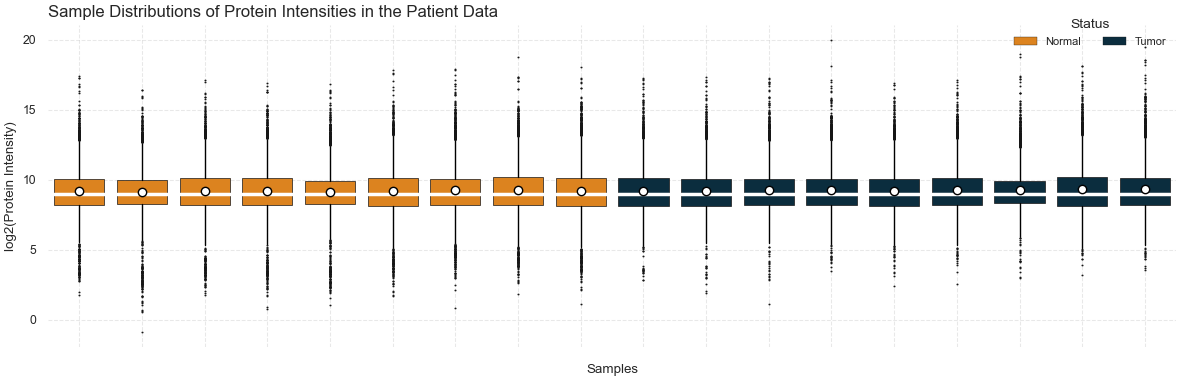

In [16]:
plot_data = np.log2(centered_data).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    metadata[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(12, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)
# Set the x-axis labels

ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SamplesDistribution_Boxplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Density Plots

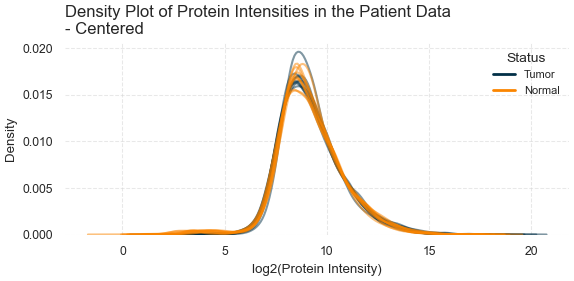

In [17]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(centered_data),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Protein Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Protein Intensities in the Patient Data \n- Centered", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SampleDistribution_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### CV Plots

CV Data data has 14,968 rows and 4 columns


,mean,median,std
Status,,,
Normal,39.4660,33.4741,24.0563
Tumor,35.8371,30.9596,20.6731


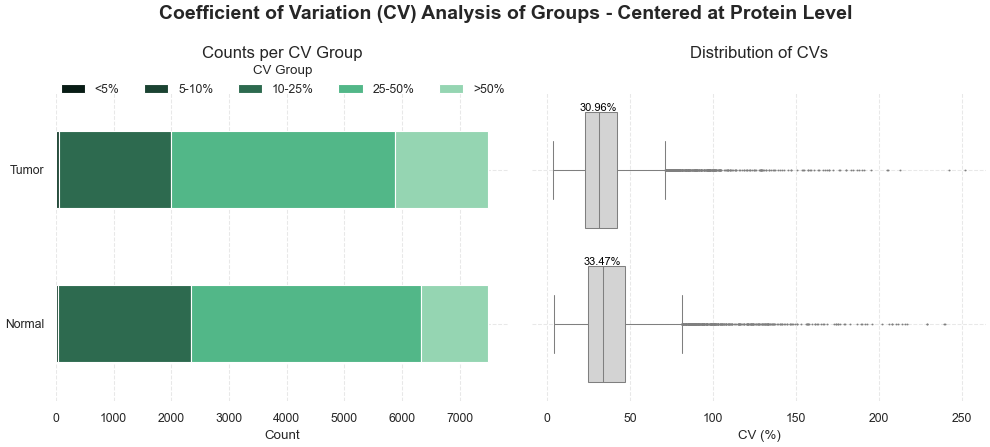

In [18]:
cv_data = pd.DataFrame(index = centered_data.index)
for k, v in status_dict.items():
    cv_data[k] = utils.cv_numpy(
        centered_data[v].values,
        axis=1,
        ignore_nan=True,
        format = "percent"
    )

medians = cv_data.median()

plot_data = cv_data.reset_index().melt(
    id_vars="Protein",
    var_name="Status",
    value_name="CV"
)

plot_data["CVGroup"] = pd.cut(
    plot_data["CV"],
    bins=[0, 5, 10, 25, 50, 100],
    labels=["<5%", "5-10%", "10-25%", "25-50%", ">50%"],
    right=False
).fillna(">50%")

utils.print_shape(plot_data, "CV Data")

# Create a CV figure with 2 subplots (1 x 2)
# 1: CVGroup Stacked Barplot
# 2: CV Distribution as violin
# Both horizontal
fig, axs = plt.subplots(
    1, 2, 
    figsize=(12, 4), 
    sharey=True,
    gridspec_kw={
        "width_ratios": [1, 1],
        "wspace": 0.05
    }
)

# CV Group Stacked Barplot
cv_counts = plot_data.groupby(["Status", "CVGroup"]).size().unstack().fillna(0)
cv_counts.plot(
    ax=axs[0],
    kind="barh",
    stacked=True,
    color=cv_group_palettes,
)

axs[0].set_xlabel("Count")
axs[0].set_ylabel("")
axs[0].set_title("Counts per CV Group", pad=25, fontsize=12)
# Put the legend on top with 5 columns
axs[0].legend(title="CV Group", frameon=False, bbox_to_anchor=(0.5, 1.125), ncol=5, loc="upper center")
axs[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# CV Distribution as boxplot
sns.boxplot(
    data=plot_data,
    x="CV",
    y="Status",
    ax=axs[1],
    color="lightgrey",
    linewidth=0.75,
    width=0.75,
    # outlier size
    fliersize=0.5
)

axs[1].set_xlabel("CV (%)")
axs[1].set_ylabel("")
axs[1].set_title("Distribution of CVs", pad=25, fontsize=12)
axs[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Annotate the median CVs on the boxplot
for i, v in enumerate(medians):
    axs[1].text(
        v, i-0.4, f"{v:.2f}%",
        va="center",
        ha="center",
        color="black",
        fontsize=8
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.suptitle("Coefficient of Variation (CV) Analysis of Groups - Centered at Protein Level", fontsize=14, fontweight="bold", y=1.10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCVAnalysis",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

plot_data.groupby("Status")["CV"].agg(["mean", "median", "std"])

## Correlation Analysis

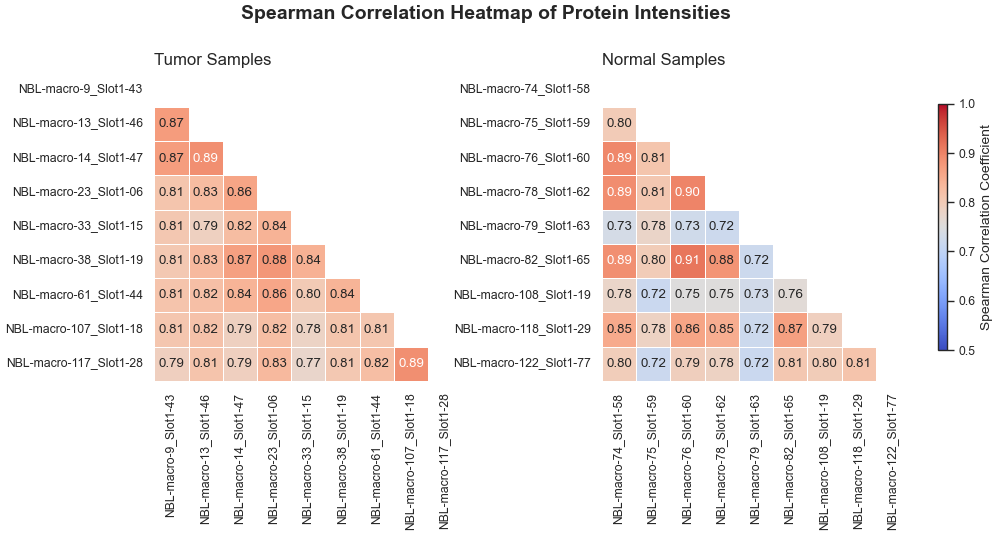

In [19]:
corrMethod = "spearman"
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 4),
    # sharey=True, sharex=True,
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)

## Tumor Samples
plot_data = centered_data[status_dict["Tumor"]].corr(method=corrMethod)

# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[0],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[0].set_title("Tumor Samples", fontsize=12, loc="left")
axes[0].set_ylabel("")
axes[0].set_xlabel("")
# axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

## Normal Samples
plot_data = centered_data[status_dict["Normal"]].corr(method=corrMethod)
# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[1],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[1].set_title("Normal Samples", fontsize=12, loc="left")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
# axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Add a title
fig.suptitle(f"{corrMethod.capitalize()} Correlation Heatmap of Protein Intensities", fontsize=14, fontweight="bold", y=1.05)
# plt.tight_layout()

## Add colorbar to the figure
cbar = axes[1].figure.colorbar(
    axes[1].collections[0], ax=axes, orientation="vertical", pad=0.01,
    fraction=0.05, aspect=30, shrink=0.8, anchor=(0.5, 0.5)
)
cbar.set_label(f"{corrMethod.capitalize()} Correlation Coefficient", fontsize=10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCorrelationHeatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Unsupservised Look

### PCA

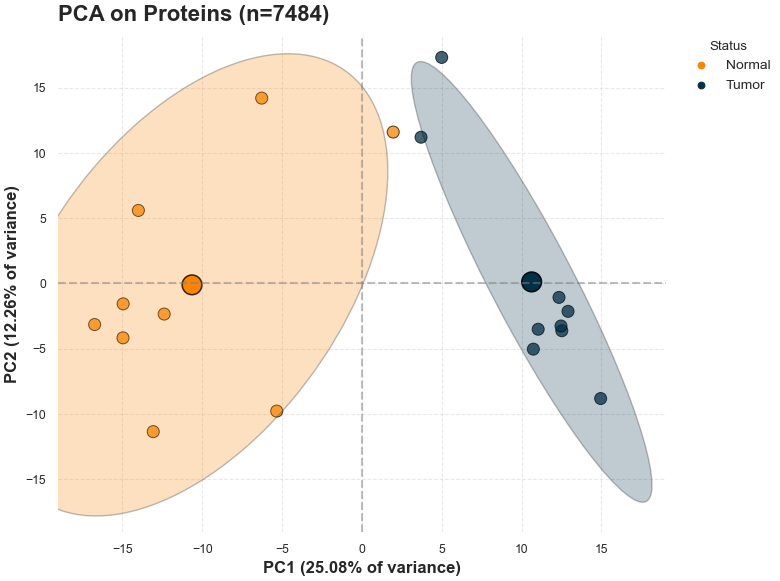

In [20]:
# PCA
# Perform PCA on the centered data
scaler = "minmax"
# Drop any missing values
complete_data = centered_data.dropna()
# Scale the data
scaled_data = utils.scale_the_data(
    complete_data,
    method=scaler,
    axis=1,
    is_log=False
)

# Run the PCA
pca = PCA()
pca_res = pca.fit_transform(scaled_data.T)
pca_exp_var = pca.explained_variance_ratio_

# Set Variables
C1 = 0
C2 = 1
hue_group = "Group"  
style_group = "Differentiation"

# Create variables to be used
comp_locs = [C1, C2]
comp_names = [f'PC{c+1}' for c in comp_locs]

# Set the x and y label names
xlabel = f'{comp_names[0]} ({pca_exp_var[comp_locs[0]]:.2%} of variance)'
ylabel = f'{comp_names[1]} ({pca_exp_var[comp_locs[1]]:.2%} of variance)'
# Build the PCA Plot Data
plot_data = pd.DataFrame(pca_res[:,comp_locs], columns=comp_names)    
plot_data['UniqueNames'] = complete_data.columns
plot_data = plot_data.merge(
    metadata[['UniqueNames', 'Group', 'Location', 'Differentiation']],
    on='UniqueNames',
    how='left'
)

# Find Centroids for each Group-Sex combination calculated with PC1 and PC2 
centroid_data = plot_data.groupby([hue_group])[comp_names].mean()
centroid_data.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Centroids
sns.scatterplot(
    data=centroid_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=200,
    edgecolor='k',
    legend=False,
    alpha=1,
)

# Technical Replicates
sns.scatterplot(
    data=plot_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=75,
    edgecolor='k',
    alpha=0.75,
)

# Setup the X and Y axis limits
# Found the max and min values of the data
minVal = plot_data.iloc[:, :2].min().min()
maxVal = plot_data.iloc[:, :2].max().max()
limit = max(abs(minVal), abs(maxVal))
offset = 0.1 * limit
limit += offset
# Set the limits
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

## Setup the title and axis labels
# Set the title
ax.set_title(f"PCA on Proteins (n={complete_data.shape[0]})", fontsize=16, fontweight="bold", pad=10, loc="left")
# Set the x-axis label
ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
# Set the y-axis label
ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
## Add 0 lines
# Add vertical line
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
# Add horizontal line
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Plot the confidence ellipses
# for hue, col in color_palettes[hue_group].items():
for hue, col in status_colors.items():
    x = plot_data.loc[(plot_data[hue_group]==hue), comp_names[0]].values
    y = plot_data.loc[(plot_data[hue_group]==hue), comp_names[1]].values
    if x.size > 1:
        plots.confidence_ellipse(x, y, plt.gca(), n_std=2, edgecolor='k', linewidth=1, alpha=0.25, facecolor=col)

ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Status")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_PCA",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Heatmap with Hierarchical Clustering

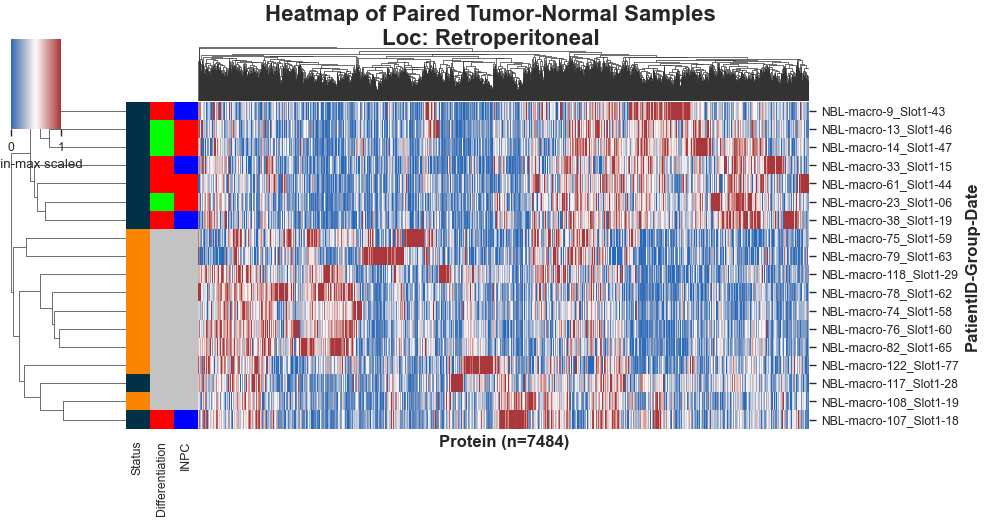

In [21]:
x_colors = pd.DataFrame(
    {
        "Status": metadata["Group"].map(status_colors),
        "Differentiation": metadata["Differentiation"].fillna("NA").map({
            "PD": "#ff0000",
            "UD": "#0000ff",
            "Diff": "#00ff00",
            "NA": "#c3c3c3"
        }),
        "INPC": metadata["INPC"].fillna("NA").map({
            "FH": "#ff0000",
            "UH": "#0000ff",
            "NA": "#c3c3c3"
        }),
    }
).set_index(metadata["UniqueNames"])

g = sns.clustermap(
    scaled_data.T,
    cmap="vlag",
    vmin=0,
    vmax=1,
    figsize=(10, 5),
    # method="ward",
    # metric="euclidean",
    row_cluster=True,
    col_cluster=True,
    xticklabels=False,
    # yticklabels=False,
    cbar_kws={
        "label": "min-max scaled",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.15,
        "aspect": 10,
    },
    rasterized=True,
    row_colors=x_colors,
    dendrogram_ratio=(0.15, 0.15),  
)

# Set the title
g.figure.suptitle(
    "Heatmap of Paired Tumor-Normal Samples\nLoc: Retroperitoneal",
    fontsize=16,
    fontweight="bold",
    y=1.05,
)

# Sex y axis-label as Protein(n={})
g.ax_heatmap.set_xlabel("Protein (n={})".format(scaled_data.shape[0]), fontsize=12, fontweight="bold")
g.ax_heatmap.set_ylabel("PatientID-Group-Date", fontsize=12, fontweight="bold")

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_Heatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Statistical Analysis

### Determine Equivalence Boundary (LFC) and T-Test LFC Boundary for QuEStVar

Total iterations: 10000



Power Analysis Results:
-----------------------

Input Parameters:
  - Target power: 0.90
  - Sample size (rep) per Group: 10
  - Mean Intra-sample CV: 25.00%
  - Number of Proteins: 1000
  - Significance threshold (p-value): 0.05
  - P-value correction method: fdr
  - Simulation Repeats: 1000

Simulation Results:
Symmetrical equivalence boundaries tested = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
  - The minimum symmetrical equivalence boundary for target: 0.50


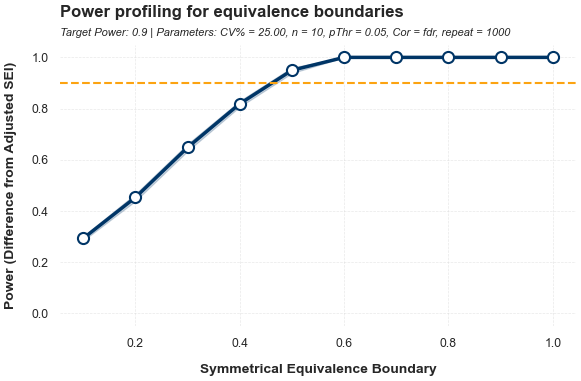

In [22]:
# Search for the optimal equivalence boundary
## Parameter to check
eqBoundary = None
eq_boundaries = np.linspace(0.1, 1.0, 10)

## Essential parameters
power = 0.90
nRep = 10
cvMean = 25
## Secondary parameters
nPrts = 1000
pThr = 0.05
corr = 'fdr'
dfThr = 1.0
cvThr = 10**5
nRepeats = 1000
nCores = None       # Use all available cores
# Simulated data parameters
int_mu = 18
int_sd = 1
int_log2 = True
cv_k = 2
cv_theta = 0.5

# Establish the Adjusted SEI
true_SEI = 1
adjs_SEI = 1 - cvMean/100

# Generate the CV distribution from the mean
cv_dist = tests.skewed_distribution(
    mu = cvMean,
    k = 2,
    theta = 0.5,
    size = nPrts
) / 100

cv_data = pd.DataFrame({
    "cvMean": cvMean,
    "cvDist": cv_dist
})

iterations = []
for eqThr in eq_boundaries:
    for i in range(nRepeats):
        iterations.append((
            cvMean, eqThr, nPrts, nRep, pThr, dfThr, cvThr, corr, i, int_mu, int_sd, int_log2, cv_k, cv_theta
        ))
print(f"Total iterations: {len(iterations)}")

# Run the simulation
results_df = tests.multiprocess_simulation(
    iterations = iterations,
    nCores = 28
)
# Calculate the power from SEI
results_df["calc_SEI"] = results_df["calc_SEI"].astype(float)
results_df["calc_power"] = results_df["calc_SEI"].apply(
    lambda x: tests.calculate_power(
        simulated_sei=x,
        target_sei=adjs_SEI
    )
)

# Print the results
tests.print_power_analysis_results(
    results_df = results_df,
    power = power,
    eqBoundaries = eq_boundaries,
    nRep = nRep,
    cvMean = cvMean,
    nPrts = nPrts,
    pThr = pThr,
    corr = corr,
    # dfThr = dfThr,
    # cvThr = cvThr,
    nRepeat = nRepeats
)
# Visualize the power profile
plots.single_variable_power_profile(
    results_df,
    x_axis_variable="eqThr",
    y_axis_variable = "calc_power",
    target_power = power,
    figtitle="Power profiling for equivalence boundaries",
    xlabel="Symmetrical Equivalence Boundary",
    save=True,
    filepath=figure_path,
    filename="powerProfile_eqThr_linePlot",
    fileformat=figure_formats,
)

### Running QuEStVar and Visualizing the Antlers

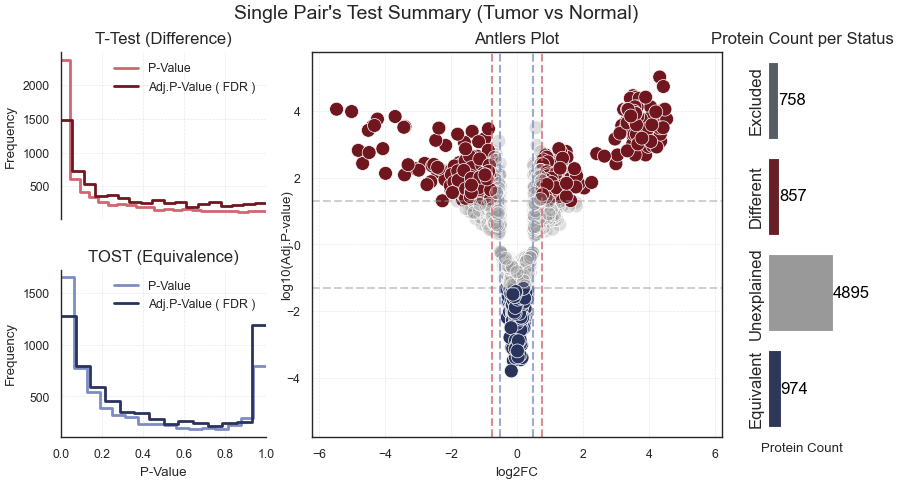

In [23]:
s1_arr = centered_data[status_dict["Tumor"]].values
s2_arr = centered_data[status_dict["Normal"]].values
res_df, info_df = tests.run_questvar(
    S1_arr = s1_arr,
    S2_arr = s2_arr,
    is_log2 = False,
    cv_thr=0.75,
    p_thr = 0.05, 
    df_thr = 0.75,
    eq_thr = 0.5,
    var_equal=True,
    is_paired=True,
)

res_df["Status"] = res_df["Status"].replace({
    0: "Unexplained",
    -1: "Different",
    1: "Equivalent"
})

res_df = res_df.join(centered_data.index.to_series().reset_index(drop=True))

plots.single_pair_summary(
    data = res_df,
    total_proteins = centered_data.shape[0],
    pair_names=["Tumor", "Normal"],
    dfThr = 0.75,
    eqThr = 0.5,
    save=True,
    filepath=figure_path,
    filename="QuEStVar_PairSummary",
    fileformat=figure_formats,
)

In [24]:
# Save the results
res_df.to_csv(f"{output_path}QuEStVar_PairSummary.csv", index=False)
res_df

,N1,N2,log2FC,df_p,df_adjp,eq_lp,eq_ladjp,eq_up,eq_uadjp,eq_p,eq_adjp,comb_p,comb_adjp,log10(pval),log10(adj_pval),Status,Protein
0,9.0000,9.0000,-0.2044,0.6394,0.7550,0.0660,0.1090,0.2507,0.3321,0.2507,0.3321,0.2507,0.3321,-0.6008,-0.4787,Unexplained,A0A024RBG1
2,9.0000,9.0000,0.8788,0.2403,0.3947,0.7003,0.7951,0.0409,0.0708,0.7003,0.7951,0.2403,0.3947,0.6192,0.4037,Unexplained,A0A075B6S2
3,9.0000,9.0000,0.0481,0.8855,0.9286,0.1003,0.1538,0.0645,0.1035,0.1003,0.1538,0.1003,0.1538,-0.9987,-0.8130,Unexplained,A0A0B4J1V6
4,9.0000,9.0000,0.6959,0.1879,0.3333,0.6520,0.7501,0.0192,0.0379,0.6520,0.7501,0.1879,0.3333,0.7261,0.4771,Unexplained,A0A0B4J2H0
5,9.0000,9.0000,0.3378,0.2509,0.4079,0.2844,0.3748,0.0077,0.0181,0.2844,0.3748,0.2844,0.3748,-0.5461,-0.4262,Unexplained,A0A2Z4LIS9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,9.0000,9.0000,0.7772,0.0050,0.0324,0.8958,0.9637,0.0001,0.0010,0.8958,0.9637,0.0050,0.0324,2.3039,1.4890,Different,Q9Y6X3
7479,9.0000,9.0000,-0.0280,0.8849,0.9283,0.0113,0.0259,0.0179,0.0358,0.0179,0.0358,0.0179,0.0358,-1.7476,-1.4466,Equivalent,Q9Y6X8
7480,9.0000,9.0000,0.7090,0.0085,0.0445,0.8315,0.9113,0.0002,0.0013,0.8315,0.9113,0.0085,0.0445,2.0698,1.3519,Unexplained,Q9Y6X9
7481,9.0000,9.0000,-0.0387,0.8423,0.9001,0.0105,0.0247,0.0199,0.0389,0.0199,0.0389,0.0199,0.0389,-1.7011,-1.4103,Equivalent,Q9Y6Y0


## Enrichment Analysis

### Statistically Different Proteins

#### Run Enrichment Analysis on Different Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 11603 proteins as custom background
  - running multi-query enrichment with 2 queries
      - using 391 proteins for 'Tumor-Up' enrichment analysis
      - using 466 proteins for 'Tumor-Down' enrichment analysis
  - will use the 'gProf_pval0.001_Difference' as analysis name for id and save files

Background length: 11603
Tumor-Up: 391
Tumor-Down: 466


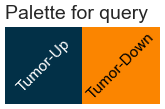

In [25]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001  
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
# background = None

enrichment_sets = {
    "Tumor-Up": list(set(
        res_df[
            (res_df["Status"] == "Different") & (res_df["log2FC"] > 0)
        ]["Protein"]
    )),
    "Tumor-Down": list(set(
        res_df[
            (res_df["Status"] == "Different") & (res_df["log2FC"] < 0)
        ]["Protein"]
    ))
}
query_palette = {
    "Tumor-Up": "#023047",
    "Tumor-Down": "#fb8500"
}
queries = ["Tumor-Up", "Tumor-Down"]

analysis_name = "gProf_pval{}_Difference".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

print()
print(f"Background length: {len(background)}")
# [k, len(v) for k, v in enrich.items()]
for k, v in enrichment_sets.items():
    print(f"{k}: {len(v)}")

plots.color_palette(
    query_palette,
    name = "query"
)

In [26]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Difference_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Difference_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

df_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {df_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    df_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 2
Number of terms per query:
   Tumor-Down -> 7880
   Tumor-Up -> 7678
Number of Unique enriched terms: 10923
Number of total terms saved: 15558
Enrichment result are prepared in 00h:00m:07s

After the p-value cutoff of 0.001 there are total of 178 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Tumor-Up -> 31
   Tumor-Down -> 147


### Statistically Equivalent Proteins

#### Run the Enrichment Analysis on Equivalent Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 11603 proteins as custom background
      - using 974 proteins for 'Equivalent' enrichment analysis
  - will use the 'gProf_pval0.001_Equivalence' as analysis name for id and save files


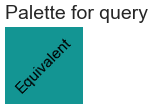

In [27]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001 
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
# background = None

enrichment_sets = {
    "Equivalent": list(set(
        res_df[
            res_df["Status"] == "Equivalent"
        ]["Protein"]
    ))
}
query_palette = {
    "Equivalent": def_colors[0]
}
queries = ['Equivalent']

analysis_name = "gProf_pval{}_Equivalence".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

plots.color_palette(
    query_palette,
    name = "query"
)

In [28]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Equivalence_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Equivalence_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

eq_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {eq_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    eq_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 1
Number of terms per query:
   Equivalent -> 10987
Number of Unique enriched terms: 10987
Number of total terms saved: 10987
Enrichment result are prepared in 00h:00m:05s

After the p-value cutoff of 0.001 there are total of 411 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Equivalent -> 411


## Enrichment Summary 

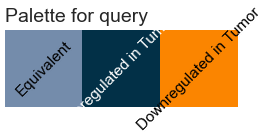

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents
0,Downregulated in Tumor,GO:CC,GO:0005739,mitochondrion,True,0.0000,0.0000,22.4158,15.0000,2.6325,0.0922,"['GO:0005737', 'GO:0043231']"
1,Downregulated in Tumor,GO:CC,GO:0005737,cytoplasm,True,0.0000,0.0000,18.4441,15.0000,1.2700,0.0445,"['GO:0005622', 'GO:0110165']"
2,Downregulated in Tumor,GO:MF,GO:0016491,oxidoreductase activity,True,0.0000,0.0000,17.0469,15.0000,3.5546,0.1245,['GO:0003824']
3,Downregulated in Tumor,KEGG,KEGG:01100,Metabolic pathways,True,0.0000,0.0000,15.5196,15.0000,2.5101,0.0880,['KEGG:00000']
4,Downregulated in Tumor,GO:CC,GO:0005759,mitochondrial matrix,True,0.0000,0.0000,15.4997,15.0000,3.7282,0.1306,"['GO:0005739', 'GO:0070013']"
...,...,...,...,...,...,...,...,...,...,...,...,...
406,Equivalent,REAC,REAC:R-HSA-68949,Orc1 removal from chromatin,True,0.0010,0.0010,3.0110,3.0110,2.9446,0.2273,['REAC:R-HSA-69052']
407,Equivalent,REAC,REAC:R-HSA-3371453,Regulation of HSF1-mediated heat shock response,True,0.0010,0.0010,3.0110,3.0110,2.9446,0.2273,['REAC:R-HSA-3371556']
408,Equivalent,REAC,REAC:R-HSA-69615,G1/S DNA Damage Checkpoints,True,0.0010,0.0010,3.0061,3.0061,3.0743,0.2373,['REAC:R-HSA-69620']
409,Equivalent,REAC,REAC:R-HSA-72662,Activation of the mRNA upon binding of the cap...,True,0.0010,0.0010,3.0061,3.0061,3.0743,0.2373,['REAC:R-HSA-72737']


In [29]:
query_palette = {
    "Equivalent": "#748cab",
    "Upregulated in Tumor": "#023047",
    "Downregulated in Tumor": "#fb8500"
}
plots.color_palette(
    query_palette,
    name = "query"
)
enrichment_data = pd.concat([df_enrichment, eq_enrichment])
enrichment_data['query'] = enrichment_data['query'].replace({
    "Tumor-Up": "Upregulated in Tumor",
    "Tumor-Down": "Downregulated in Tumor",
    "Equivalent": "Equivalent"
})
enrichment_data

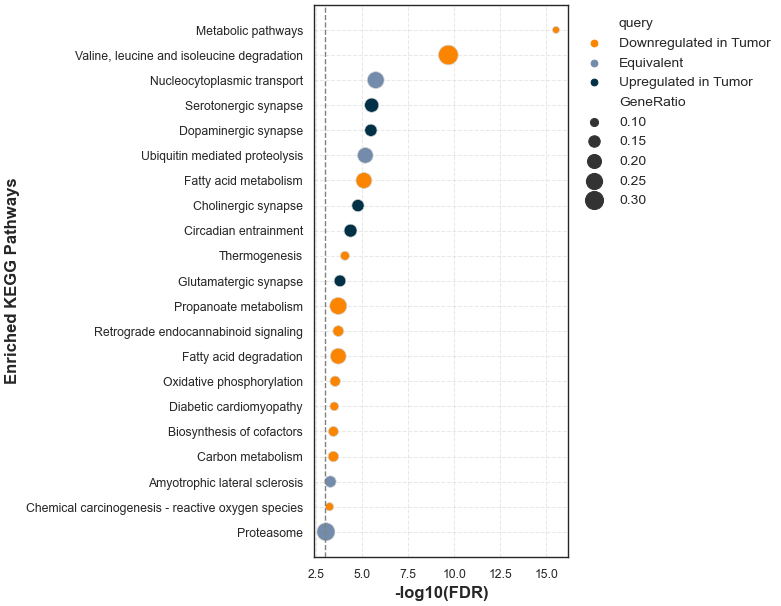

In [30]:
cur_source = "KEGG"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()

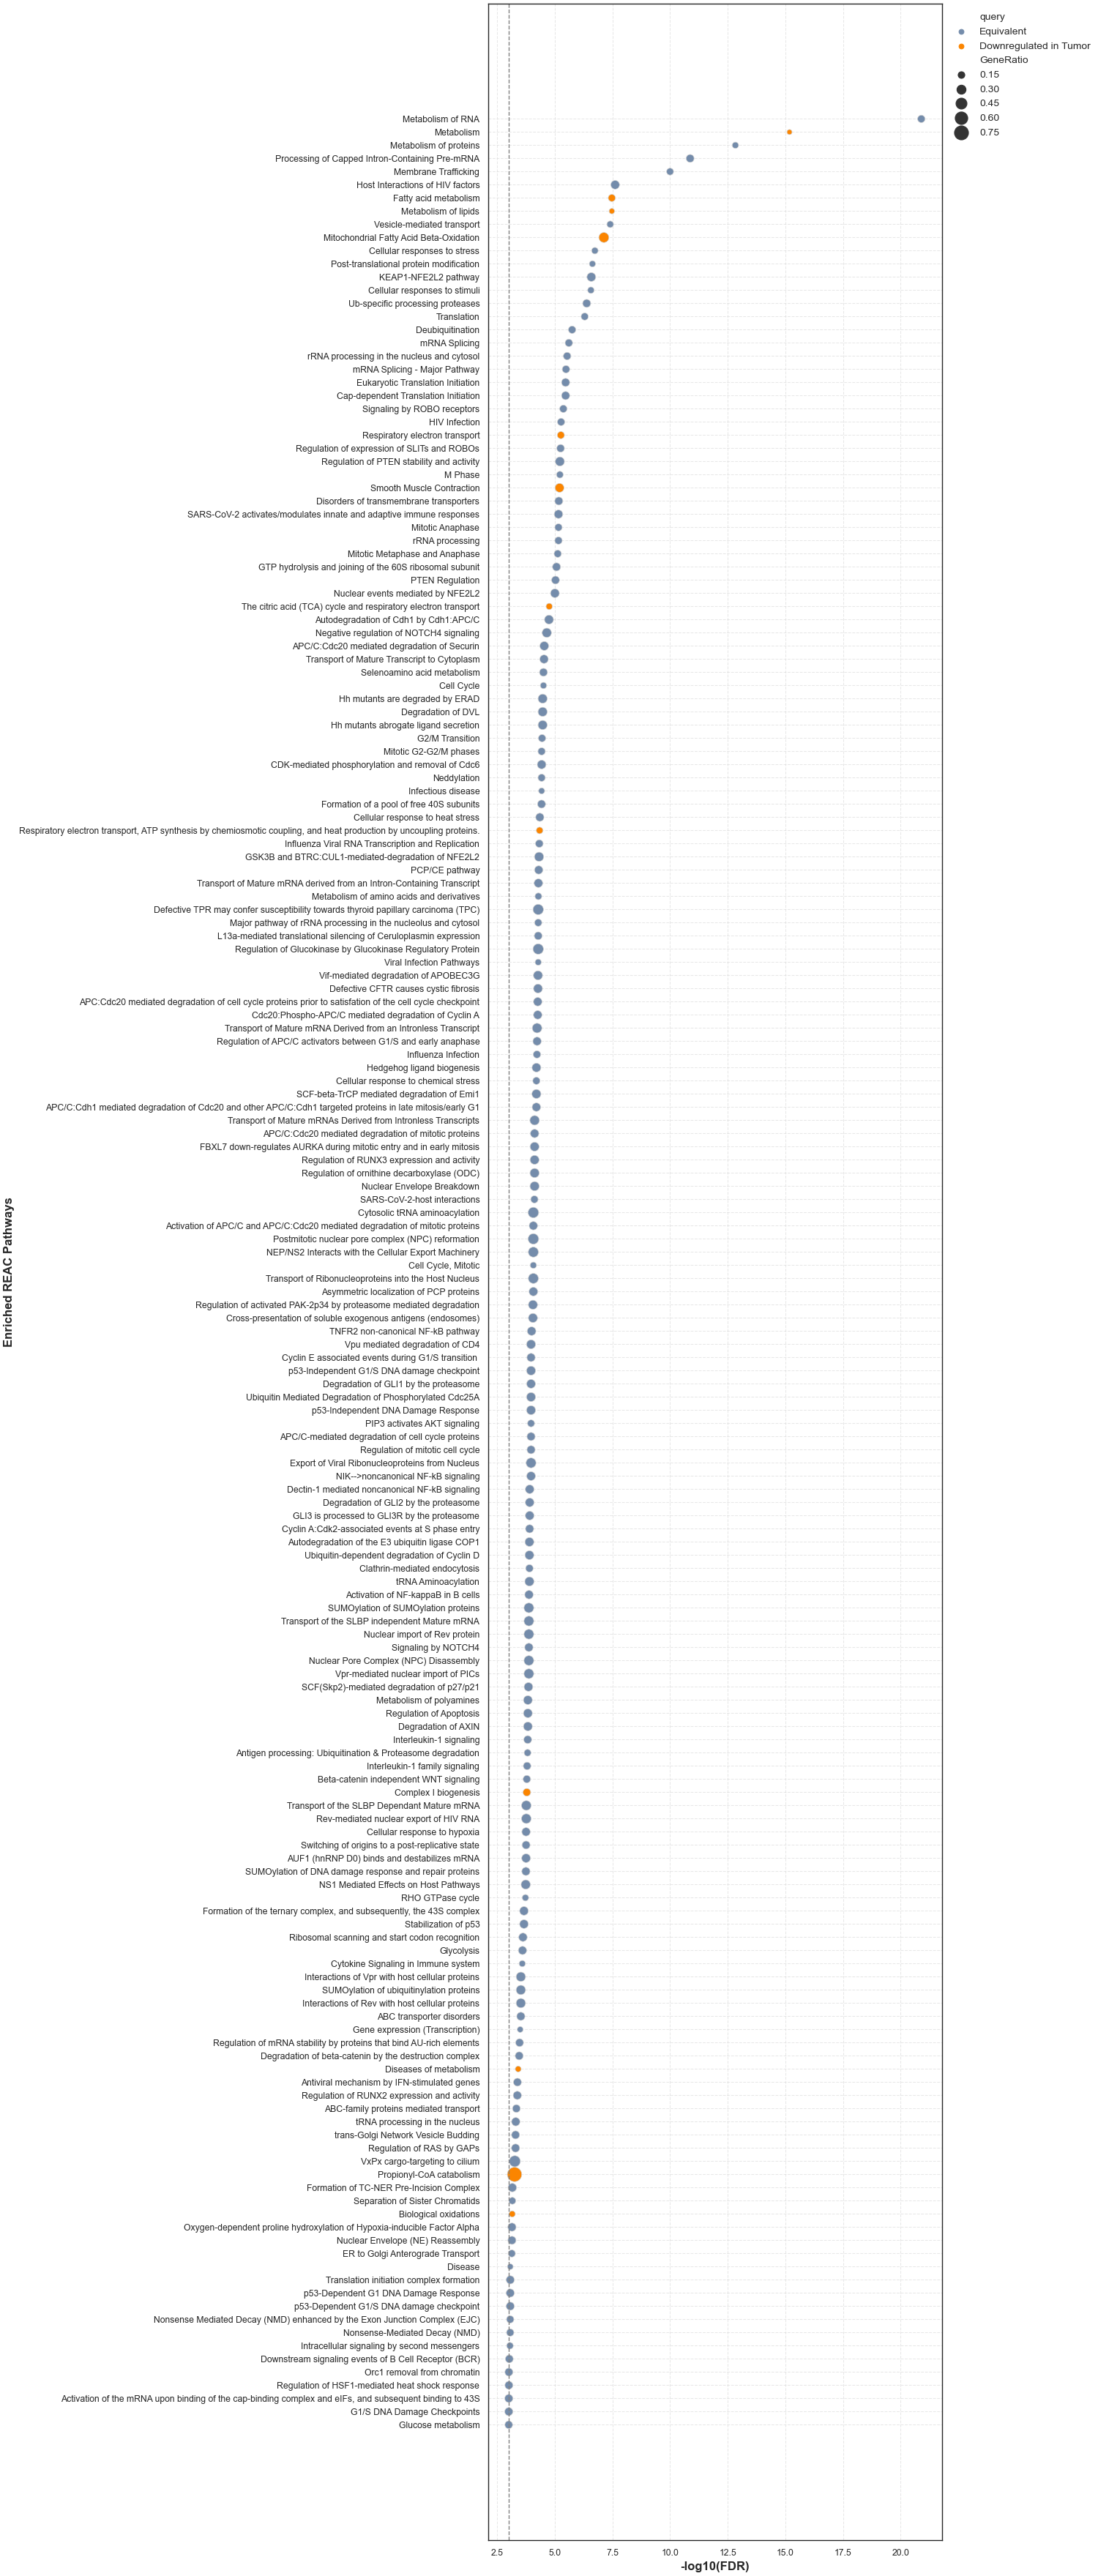

In [31]:
cur_source = "REAC"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout() 